# DASKify pandas dataframe

General advice: if data fits in memory: use pandas, if not: use dask.dataframe

In [1]:
from dask.distributed import Client
client = Client(n_workers=4)

C:\Users\jem\Anaconda3\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56350 instead
  warnings.warn(


## Download data

4 files each around 100MB with unprocessed altimetry data

In [2]:
sats = ["3a","c2","j2","j3"]
files = [f"raw_alti_scs_{sat}.csv" for sat in sats]
files

['raw_alti_scs_3a.csv',
 'raw_alti_scs_c2.csv',
 'raw_alti_scs_j2.csv',
 'raw_alti_scs_j3.csv']

In [3]:
import urllib.request
for fn in files:
    urllib.request.urlretrieve("https://automodelstorage.blob.core.windows.net/globalaltimetry/scsaltimetry/"+fn, fn)

## Pandas DataFrame

In [4]:
import glob
import pandas as pd

In [5]:
#df = pd.read_csv("raw_alti_scs_*.csv") # does not work - you need glob and pd.concat
df = pd.concat([pd.read_csv(f) for f in glob.glob("raw_alti_scs_*.csv")], ignore_index = True)

In [6]:
len(df)

2564991

In [7]:
df.max()

date                  2018-12-31 23:32:10.325356
lon                                    139.70966
lat                                    41.727701
satellite                                     j3
adt                                    3188.6402
adt_dhi                                4163.4317
swh                                       32.763
swh_rms                                32.703003
wind_speed                                119.18
distance_from_land                 766428.670861
range_numval                                  21
range_rms                                 3.2765
dtype: object

## DASK DataFrame

In [8]:
import dask.dataframe as dd

In [9]:
ddf = dd.read_csv("raw_alti_scs_*.csv", parse_dates=True)
#ddf = ddf.set_index("date")

In [10]:
ddf.head()

,date,lon,lat,satellite,adt,adt_dhi,swh,swh_rms,wind_speed,distance_from_land,range_numval,range_rms
0,2018-01-01 00:45:22,137.859016,-5.281916,3a,NaN,NaN,0.000,0.000,1.18,0.000000,18,0.2721
1,2018-01-01 00:45:23,137.845849,-5.341000,3a,NaN,NaN,0.400,0.843,1.18,0.000000,21,2.0938
2,2018-01-01 00:45:24,137.832681,-5.400083,3a,1.4730,0.9930,0.000,0.000,1.18,2773.750771,18,0.0917
3,2018-01-01 00:45:25,137.819511,-5.459166,3a,1.2870,0.8010,0.390,0.620,1.18,9307.329273,20,0.1214
4,2018-01-01 00:45:26,137.806339,-5.518249,3a,1.2933,0.7971,0.216,0.477,1.38,15840.920227,21,0.1030


In [11]:
len(ddf)

2564991

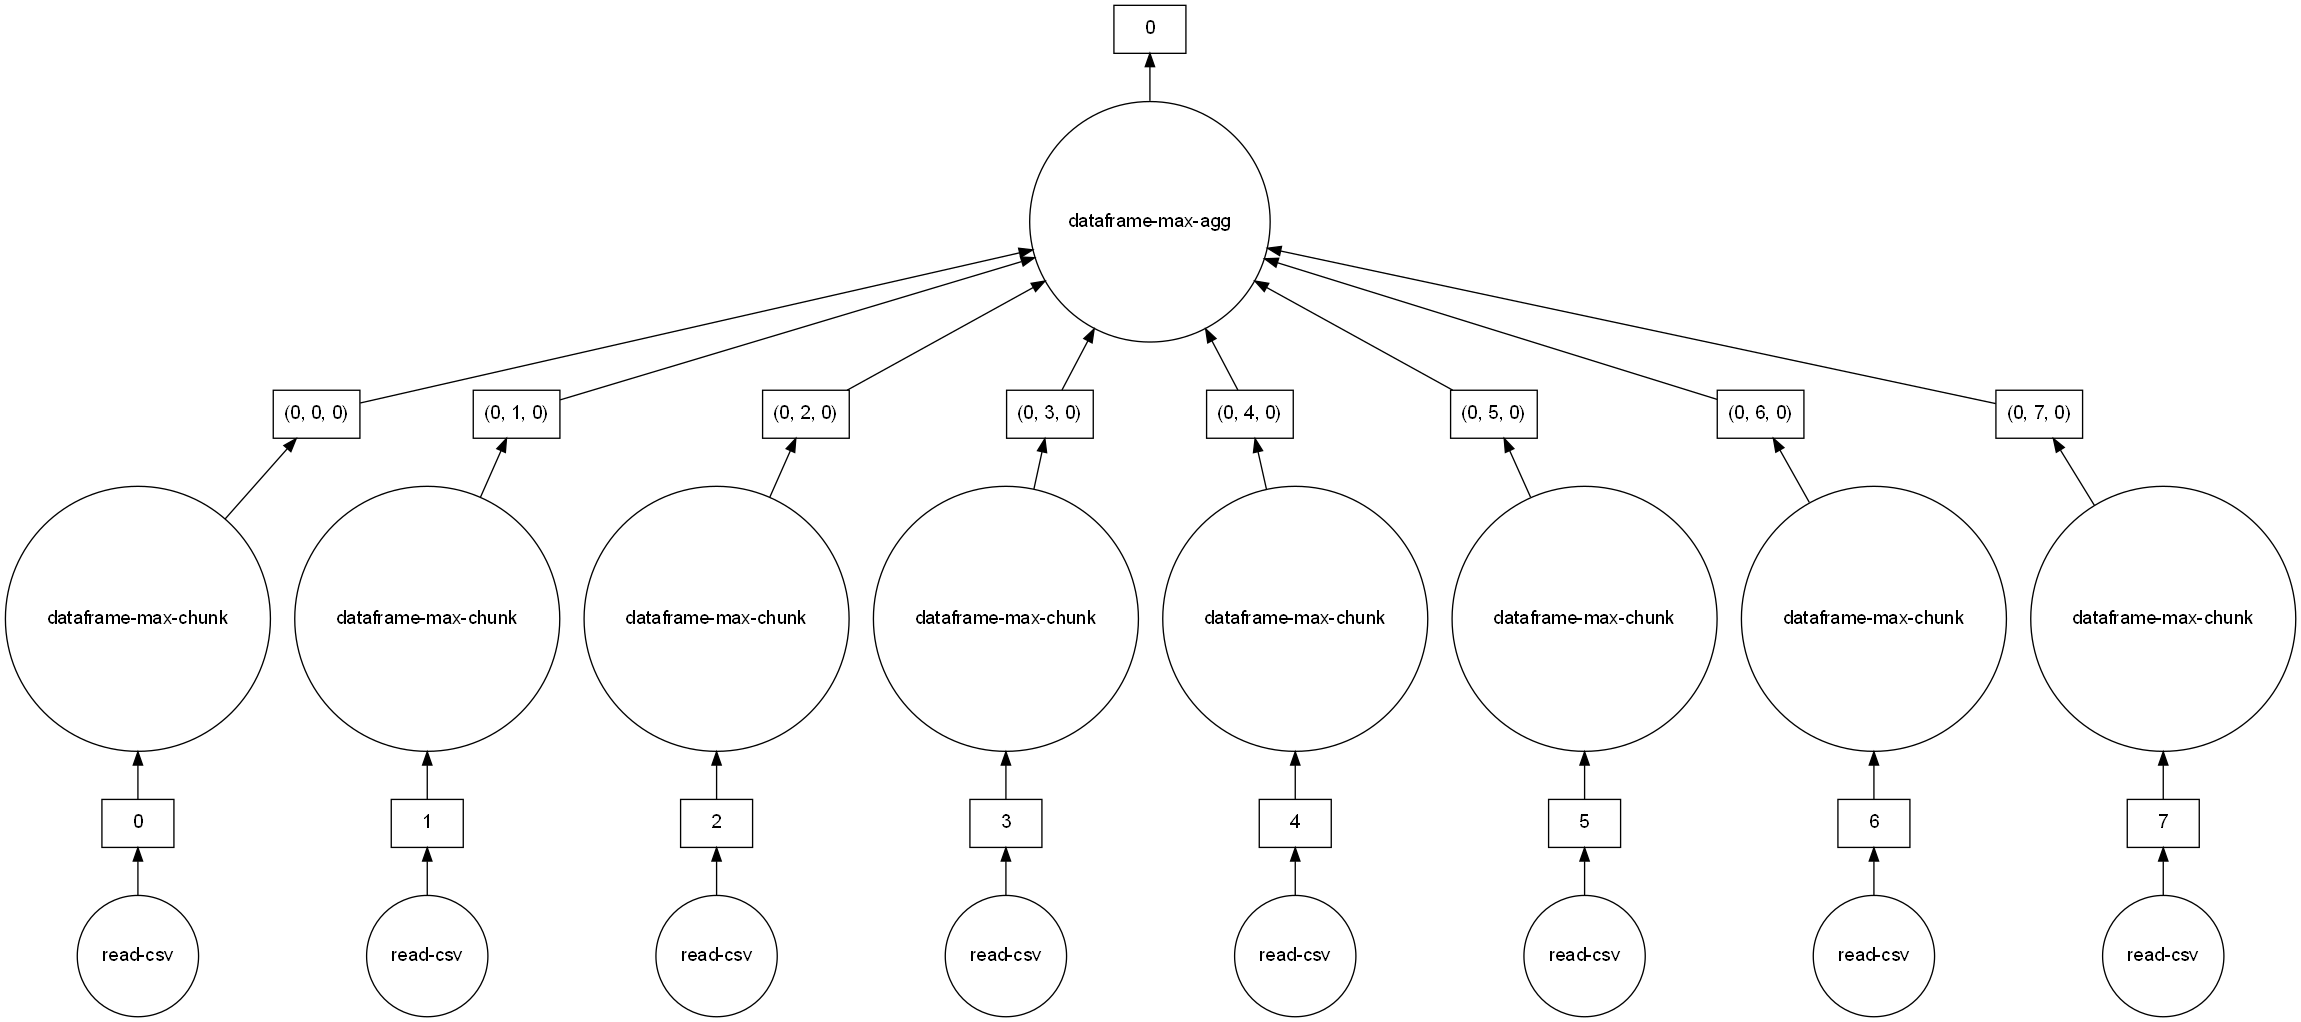

In [12]:
ddfmax = ddf.max()
ddfmax.visualize()

In [13]:
ddfmax.compute()

date                  2018-12-31 23:32:10.325356
lon                                    139.70966
lat                                    41.727701
satellite                                     j3
adt                                    3188.6402
adt_dhi                                4163.4317
swh                                       32.763
swh_rms                                32.703003
wind_speed                                119.18
distance_from_land                 766428.670861
range_numval                                  21
range_rms                                 3.2765
dtype: object

In [14]:
mask = ddf.swh_rms < 0.2
res = ddf.loc[mask, "swh"].mean()
res

dd.Scalar<series-..., dtype=float64>

In [15]:
res.compute()

0.2628205225993002

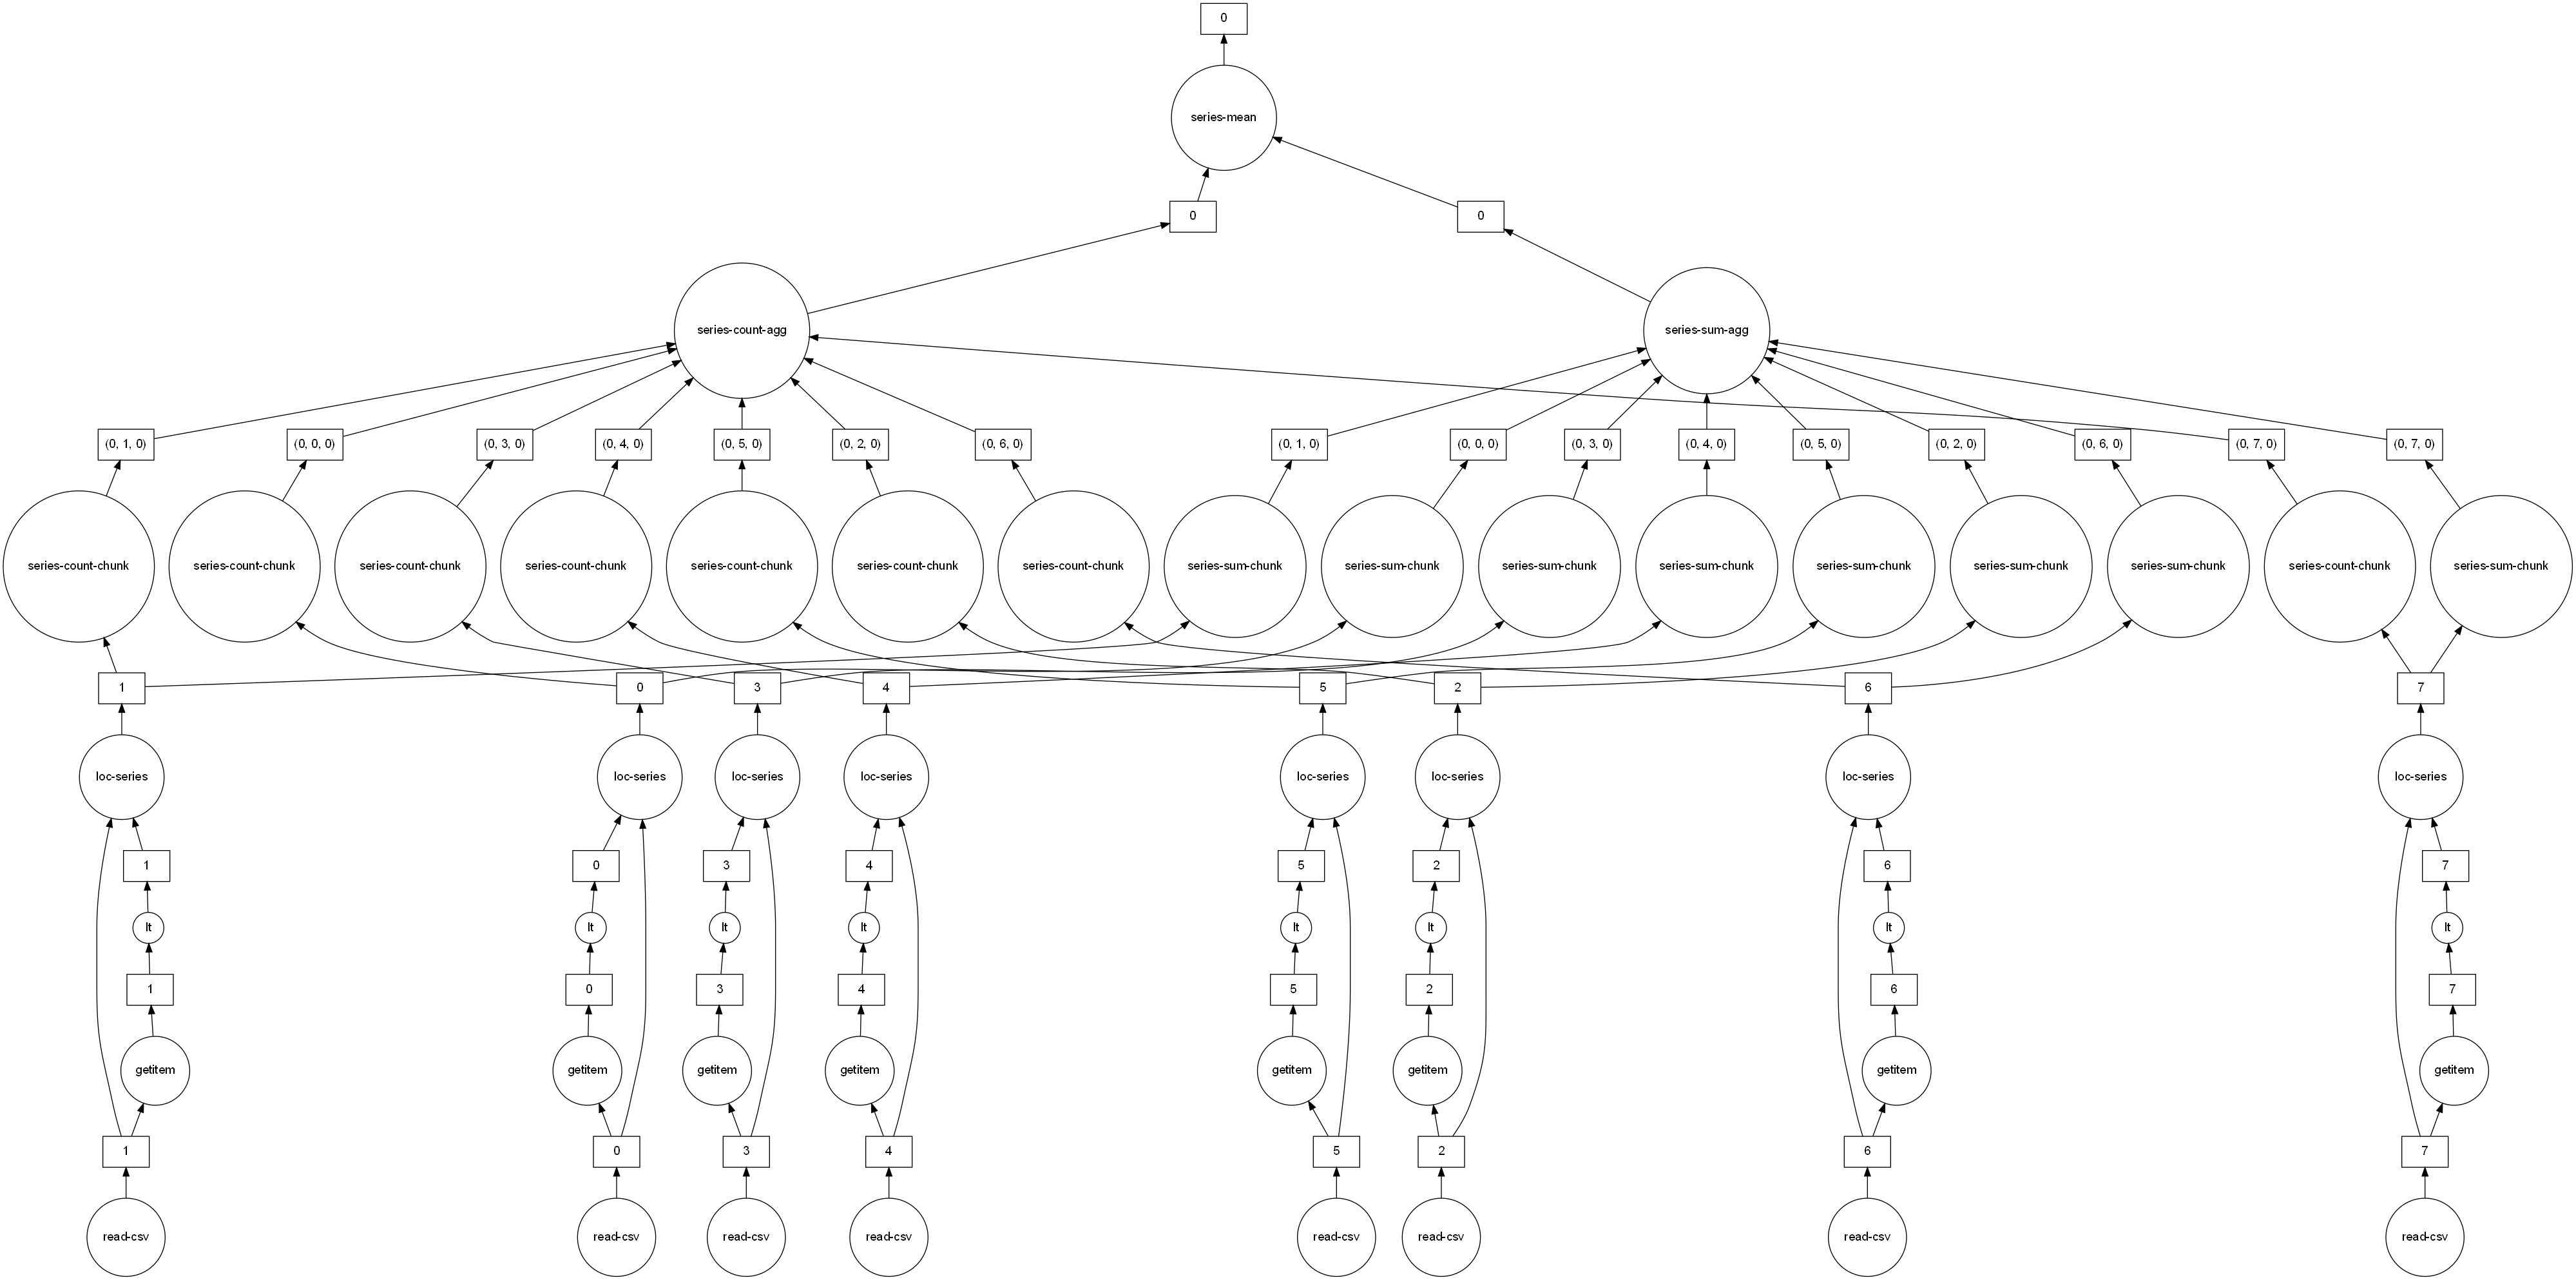

In [16]:
res.visualize()

In [ ]:
client.close()